# Step 1 Extract data


In [17]:
import zipfile
from pathlib import Path

# open zip file and extract all content
with zipfile.ZipFile("./data.zip", "r") as f:
  print(f"Unzipping zip file")
  f.extractall(".")


Unzipping zip file


# Step 2 import all required lib

In [1]:
!pip install -q torchinfo

In [2]:
import torch
import torchvision
from torchinfo import summary

print(f"torch: {torch.__version__}")
print(f"torcvision: {torchvision.__version__}")

torch: 1.13.1+cu116
torcvision: 0.14.1+cu116


# Setup device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Step 3 Datasets and Dataloader

In [28]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_CPUS = os.cpu_count()

def createDataLoaders(train_dir:str,
                      test_dir:str,
                      train_transform:transforms.Compose,
                      test_transform:transforms.Compose,
                      batch_size:int,
                      num_workers=NUM_CPUS):
  
  train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

  train_dataloder = DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=num_workers,
                               pin_memory=True)
  
  test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers,
                               pin_memory=True)
  
  class_names = train_dataset.classes

  return train_dataloder, test_dataloader, class_names

# Step 4 get weights and model

In [6]:
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [7]:
model = torchvision.models.alexnet(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
auto_tranform = weights.transforms()
auto_tranform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

# Step 5 Create Dataloaders

In [29]:
train_str = "data/train"
test_str = "data/valid"
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_name = createDataLoaders(train_dir=train_str,
                                                                test_dir=test_str,
                                                                train_transform=train_transform,
                                                                test_transform=test_transform,
                                                                batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_name

(<torch.utils.data.dataloader.DataLoader at 0x7fe11f02ee50>,
 ['bear', 'gorilla', 'other'])

# Step 6 modify classifier layer

In [34]:
for param in model.parameters():
  param.requires_grad = False

model.classifier[6] = torch.nn.Linear(4096, len(class_name))
model.classifier.add_module("7", torch.nn.LogSoftmax(dim = 1))

model.to(device)

summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

# Step 7 set loss_fn and optimizer

In [36]:
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

loss_fn, optimizer

(NLLLoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

# Step 8 create engine train, test

In [53]:
from tqdm.auto import tqdm
from typing import Tuple, Dict, List

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(y_pred, dim=1) # softmax is already added as layer [option]
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  
  model.eval()

  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      y_pred_class = torch.argmax(y_pred,dim=1) # softmax is already added as layer [optional]
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  results= {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    print(
        f"train_loss: {train_loss:.3f} | "
        f"train_acc: {train_acc:.3f} | "
        f"test_loss: {test_loss:.3f} | "
        f"test_acc: {test_acc:.3f} | "
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [54]:
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               epochs=5,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

train_loss: 0.020 | train_acc: 1.000 | test_loss: 0.219 | test_acc: 0.882 | 
train_loss: 0.020 | train_acc: 1.000 | test_loss: 0.217 | test_acc: 0.882 | 
train_loss: 0.017 | train_acc: 1.000 | test_loss: 0.208 | test_acc: 0.882 | 
train_loss: 0.013 | train_acc: 1.000 | test_loss: 0.193 | test_acc: 0.900 | 
train_loss: 0.010 | train_acc: 1.000 | test_loss: 0.185 | test_acc: 0.900 | 


predection is:::bear | prob: 0.999


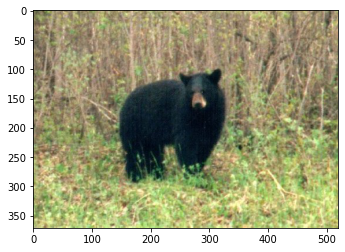

In [81]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(model: torch.nn.Module,
            image_path: str,
            transform: torchvision.transforms.Compose,
            device: torch.device):
  plt.plot(2,1,1)
  test_image = Image.open(image_path)
  plt.imshow(test_image)

  test_image_tensor = transform(test_image)
  test_image_tensor = test_image_tensor.view(1, 3, 224, 224).to(device)

  with torch.inference_mode():
    model.eval()

    out = model(test_image_tensor)
    pred = torch.argmax(out,dim=1)
    prob = torch.softmax(out, dim=1)
    print(f"predection is:::{class_name[pred]} | prob: {prob.max():.3f}")

predict(model, 'data/test/009_0098.jpg', test_transform, device)
#predict(model, 'data/test/090_0107.jpg', test_transform, device)
#predict(model, 'data/test/150_0044.jpg', test_transform, device)

In [82]:
def save_model(model: torch.nn.Module,
               target_dir:str,
               model_name: str):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "Model name should endwith .pth .pt"
  model_save_path = target_dir_path / model_name

  print(f"saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)
  
save_model(model=model, target_dir="models", model_name="tranfers_l_02_best.pth")

saving model to: models/tranfers_l_02_best.pth
